In [ ]:
import os
import pandas as pd

In [2]:
from numpy.random import normal

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
os.chdir(os.path.join(os.getcwd(),'../../..'))
import ExMAS.main
import ExMAS.utils
from ExMAS.transitize import *

In [5]:
import json
from ExMAS.utils import *

In [9]:
from ExMAS.transitize import visualizations
from ExMAS.transitize import analysis

In [255]:
inData = analysis.load_results(PATH ='transit_results', EXP_NAME = 'size_{}'.format(1300))

In [28]:
params = ExMAS.utils.get_config('ExMAS/data/configs/transit.json')  # load the default
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph

In [343]:
inData.transitize.requests = analysis.PT_utility(inData.transitize.requests, params)

In [197]:
df = inData.transitize.rm[inData.transitize.rm.solution_3==1]
df[df.kind=='ms'].tail(10)

,ride,traveller,degree,dist,ttrav,delay,u,orig_walk_time,dest_walk_time,VoT,...,destination,treq,kind,s2s_reference,door_departure,fare,solution_0,solution_1,solution_2,solution_3
1088,58623,1088,9.0,8123,1278.0,252.0,10.88,259.0,322.0,3.00e-03,...,46283291,472,ms,30391.0,724.0,3.05,0,0,0,1
1033,59486,1033,9.0,5846,879.0,321.5,10.42,190.0,312.0,3.84e-03,...,46332010,431,ms,30237.0,752.5,2.19,0,0,0,1
606,59486,606,9.0,5737,879.0,323.5,9.21,282.0,201.0,3.33e-03,...,46327182,337,ms,30237.0,660.5,2.15,0,0,0,1
1232,59486,1232,9.0,5005,866.0,88.5,7.94,232.0,138.0,3.73e-03,...,1825801466,557,ms,30252.0,645.5,1.88,0,0,0,1
1234,59486,1234,9.0,5560,866.0,70.5,9.05,249.0,402.0,3.44e-03,...,46324030,558,ms,30252.0,628.5,2.08,0,0,0,1
186,59486,186,9.0,6295,899.0,505.5,12.15,424.0,219.0,3.73e-03,...,46299326,104,ms,30275.0,609.5,2.36,0,0,0,1
597,59486,597,9.0,6022,899.0,359.5,9.25,341.0,231.0,3.01e-03,...,46296920,333,ms,30275.0,692.5,2.26,0,0,0,1
152,59486,152,9.0,5377,636.0,517.5,8.21,306.0,38.0,3.26e-03,...,46395415,80,ms,30371.0,597.5,2.02,0,0,0,1
576,59486,576,9.0,4768,636.0,541.5,7.21,37.0,288.0,2.85e-03,...,46383661,325,ms,30371.0,866.5,1.79,0,0,0,1
421,59486,421,9.0,5628,636.0,556.5,10.75,94.0,449.0,3.84e-03,...,46374403,253,ms,30371.0,809.5,2.11,0,0,0,1


In [256]:
ride_index = 59486
#ride_index = 58623
rides = inData.transitize.rides
requests = inData.transitize.requests

ride = inData.transitize.rides.loc[ride_index]
try:
    ride['high_level_indexes'] = json.loads(ride['high_level_indexes'])
except:
    pass
ride['origins'] = requests.loc[ride.indexes].origin.values
ride['destinations'] = requests.loc[ride.indexes].destination.values

private_rides = rides[rides.kind=='p'][rides['index'].isin(ride.indexes)]

s2s_rides = rides.loc[ride.high_level_indexes]

d2d_rides = rides.loc[s2s_rides.d2d_reference.values]

In [344]:
rm = inData.transitize.rm
ret = dict()
for i in range(0,4):
    ret[i]= rm[rm.traveller.isin(ride.indexes) & (rm['solution_{}'.format(i)] ==1)].set_index('traveller').sort_index().u
pd.set_option('precision', 2)
df = pd.DataFrame(ret)

n = 'utility'
df['PT'] = requests.loc[ride.indexes].u_PT.sort_index()
df.columns = pd.MultiIndex.from_tuples([(n,'p'),(n,'d2d'),(n,'s2s'),(n,'ms'),(n,'PT')])
df.loc['total'] = df.sum()
full = df

In [345]:
rm = inData.transitize.rm
ret = dict()
for i in range(0,4):
    df= rm[rm.traveller.isin(ride.indexes) & (rm['solution_{}'.format(i)] ==1)].set_index('traveller').sort_index()
    ret[i]=df.ttrav * (1+ np.random.random()/20 if i == 1 else 1)
pd.set_option('precision', 2)
df = pd.DataFrame(ret)
n = 'travel time'
df.columns = pd.MultiIndex.from_tuples([(n,'p'),(n,'d2d'),(n,'s2s'),(n,'ms')])

df = df/60
df.loc['total'] = df.sum()
full = pd.concat([full,df], axis = 1)

In [346]:
rm = inData.transitize.rm
ret = dict()
for i in range(0,4):
    df = rm[rm.traveller.isin(ride.indexes) & (rm['solution_{}'.format(i)] ==1)].set_index('traveller').sort_index()
    ret[i] = df.orig_walk_time + df['dest_walk_time']
pd.set_option('precision', 2)
df = pd.DataFrame(ret)
n = 'walk time'
df.columns = pd.MultiIndex.from_tuples([(n,'p'),(n,'d2d'),(n,'s2s'),(n,'ms')])
df.loc['total'] = df.sum()
df = df/60
df = df.fillna(0)
full = pd.concat([full,df], axis = 1)

In [347]:
rm = inData.transitize.rm
ret = dict()
for i in range(0,4):
    df = rm[rm.traveller.isin(ride.indexes) & (rm['solution_{}'.format(i)] ==1)].set_index('traveller').sort_index()
    ret[i] = df.fare
pd.set_option('precision', 2)
df = pd.DataFrame(ret)
n = 'fare'
df['PT'] = requests.loc[ride.indexes].PT_fare.sort_index()
df.columns = pd.MultiIndex.from_tuples([(n,'p'),(n,'d2d'),(n,'s2s'),(n,'ms'),(n,'PT')])
df.loc['total'] = df.sum()
df = df
df = df.fillna(0)
full = pd.concat([full,df], axis = 1)
full

utility                             travel time                 \
                p    d2d    s2s     ms     PT           p     d2d    s2s   
traveller                                                                  
152         10.26   9.91   9.91   8.21   8.40       11.20   11.33   9.45   
186         12.38  11.86  12.18  12.15  13.97       13.10   13.26  11.13   
421         11.14  10.26  10.26  10.75   7.44       11.72   11.86   9.45   
576          8.85   8.29   8.29   7.21   7.80        9.93   10.05   9.45   
597         11.30  10.88   9.93   9.25   9.37       12.53   12.68  11.13   
606         10.99  10.08  10.08   9.21  10.76       11.95   12.09  11.95   
1033        11.57  11.35  11.05  10.42  12.15       12.17   12.31  11.33   
1232         9.84   9.18   9.59   7.94  11.63       10.42   10.54  11.33   
1234        10.73  10.07   9.79   9.05  11.81       11.58   11.72  11.33   
total       97.07  91.88  91.09  84.19  93.32      104.60  105.84  96.57   

                  walk time                      fare                       \
               ms         p  d2d    s2s     ms      p    d2d    s2s     ms   
traveller                                                                    
152         10.60       0.0  0.0   5.73   5.73   8.07   5.93   2.74   2.02   
186         14.98       0.0  0.0  10.72  10.72   9.44   6.94   3.21   2.36   
421         10.60       0.0  0.0   9.05   9.05   8.44   6.21   2.87   2.11   
576         10.60       0.0  0.0   5.42   5.42   7.15   5.26   2.43   1.79   
597         14.98       0.0  0.0   9.53   9.53   9.03   6.64   3.07   2.26   
606         14.65       0.0  0.0   0.00   8.05   8.61   6.33   6.33   2.15   
1033        14.65       0.0  0.0  12.35   8.37   8.77   6.45   2.98   2.19   
1232        14.43       0.0  0.0   9.60   6.17   7.51   5.52   2.55   1.88   
1234        14.43       0.0  0.0   7.45  10.85   8.34   6.13   2.84   2.08   
total      119.93       0.0  0.0  69.85  73.88  75.36  55.41  29.02  18.84   

                  
              PT  
traveller         
152         1.11  
186         1.60  
421         1.24  
576         1.20  
597         1.45  
606         1.36  
1033        1.83  
1232        1.36  
1234        1.76  
total      12.90

In [340]:
full.index.name = 'id'

In [341]:
full

utility                             travel time                         \
            p    d2d    s2s     ms     PT           p     d2d    s2s      ms   
id                                                                             
152     10.26   9.91   9.91   8.21   7.48       11.20   11.59   9.45   10.60   
186     12.38  11.86  12.18  12.15  13.39       13.10   13.56  11.13   14.98   
421     11.14  10.26  10.26  10.75   6.62       11.72   12.13   9.45   10.60   
576      8.85   8.29   8.29   7.21   6.94        9.93   10.28   9.45   10.60   
597     11.30  10.88   9.93   9.25   8.69       12.53   12.97  11.13   14.98   
606     10.99  10.08  10.08   9.21  10.02       11.95   12.37  11.95   14.65   
1033    11.57  11.35  11.05  10.42  11.75       12.17   12.59  11.33   14.65   
1232     9.84   9.18   9.59   7.94  10.88       10.42   10.78  11.33   14.43   
1234    10.73  10.07   9.79   9.05  11.35       11.58   11.99  11.33   14.43   
total   97.07  91.88  91.09  84.19  87.11      104.60  108.26  96.57  119.93   

      walk time                      fare                             
              p  d2d    s2s     ms      p    d2d    s2s     ms    PT  
id                                                                    
152         0.0  0.0   5.73   5.73   8.07   5.93   2.74   2.02  0.19  
186         0.0  0.0  10.72  10.72   9.44   6.94   3.21   2.36  1.02  
421         0.0  0.0   9.05   9.05   8.44   6.21   2.87   2.11  0.41  
576         0.0  0.0   5.42   5.42   7.15   5.26   2.43   1.79  0.34  
597         0.0  0.0   9.53   9.53   9.03   6.64   3.07   2.26  0.77  
606         0.0  0.0   0.00   8.05   8.61   6.33   6.33   2.15  0.61  
1033        0.0  0.0  12.35   8.37   8.77   6.45   2.98   2.19  1.43  
1232        0.0  0.0   9.60   6.17   7.51   5.52   2.55   1.88  0.61  
1234        0.0  0.0   7.45  10.85   8.34   6.13   2.84   2.08  1.30  
total       0.0  0.0  69.85  73.88  75.36  55.41  29.02  18.84  6.69

In [342]:
print(full.to_latex())

\begin{tabular}{lrrrrrrrrrrrrrrrrrr}
\toprule
{} & \multicolumn{5}{l}{utility} & \multicolumn{4}{l}{travel time} & \multicolumn{4}{l}{walk time} & \multicolumn{5}{l}{fare} \\
{} &       p &    d2d &    s2s &     ms &     PT &           p &     d2d &    s2s &      ms &         p &  d2d &    s2s &     ms &      p &    d2d &    s2s &     ms &    PT \\
id    &         &        &        &        &        &             &         &        &         &           &      &        &        &        &        &        &        &       \\
\midrule
152   &   10.26 &   9.91 &   9.91 &   8.21 &   7.48 &       11.20 &   11.59 &   9.45 &   10.60 &       0.0 &  0.0 &   5.73 &   5.73 &   8.07 &   5.93 &   2.74 &   2.02 &  0.19 \\
186   &   12.38 &  11.86 &  12.18 &  12.15 &  13.39 &       13.10 &   13.56 &  11.13 &   14.98 &       0.0 &  0.0 &  10.72 &  10.72 &   9.44 &   6.94 &   3.21 &   2.36 &  1.02 \\
421   &   11.14 &  10.26 &  10.26 &  10.75 &   6.62 &       11.72 &   12.13 &   9.45 &   10.60 &       

In [148]:
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'
import matplotlib.pyplot as plt
plt.style.use(['science'])

In [149]:
import seaborn as sns
sns.color_palette("Set2",6)

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961)]

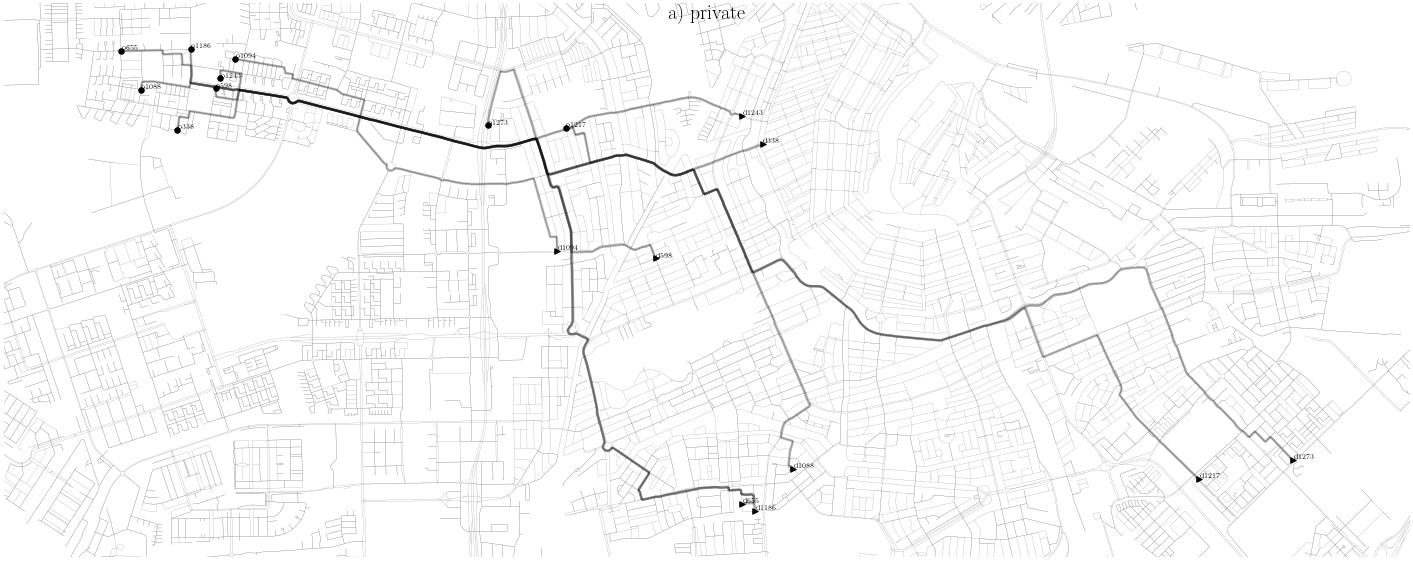

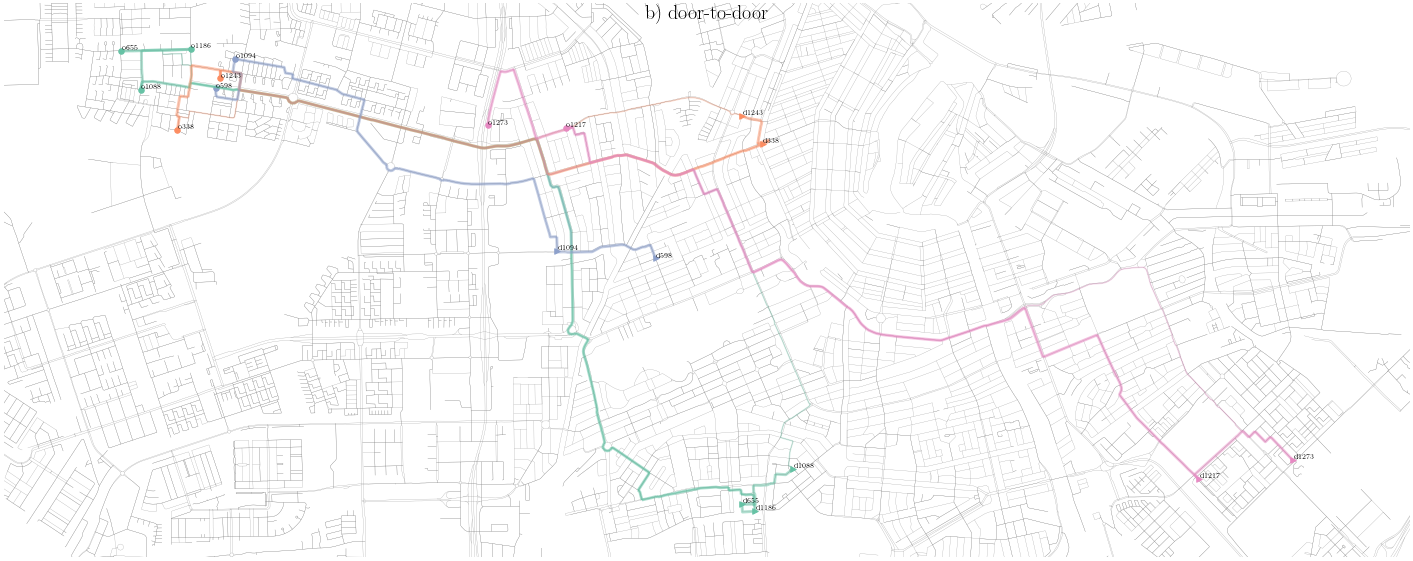

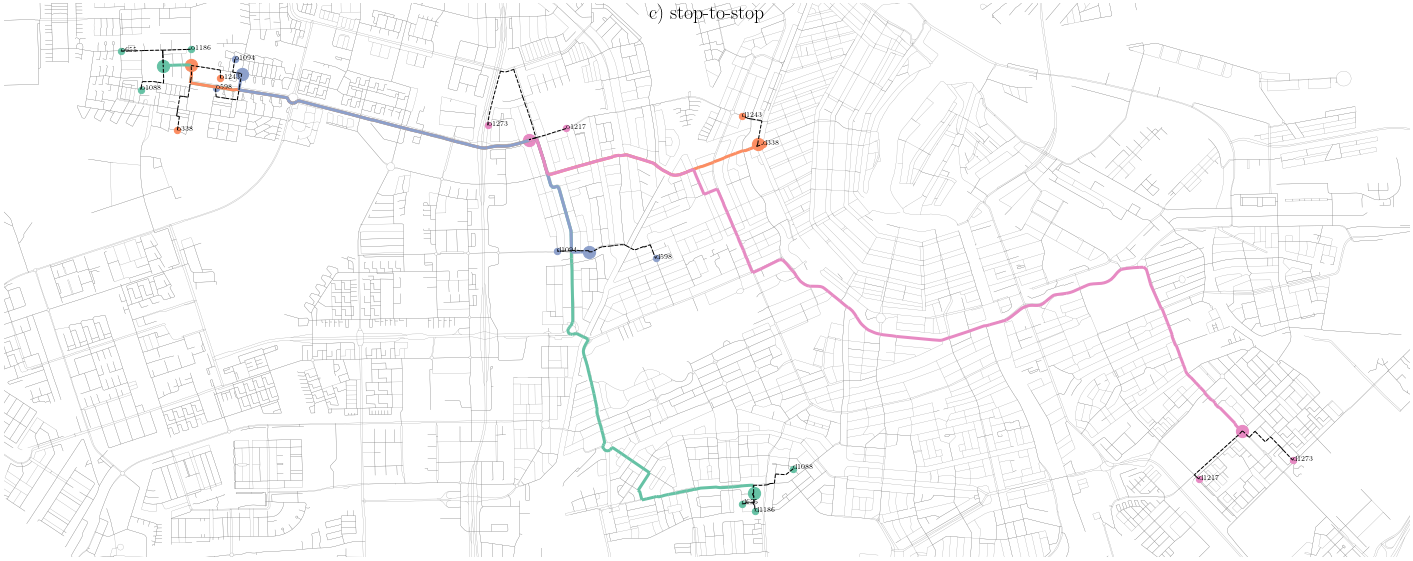

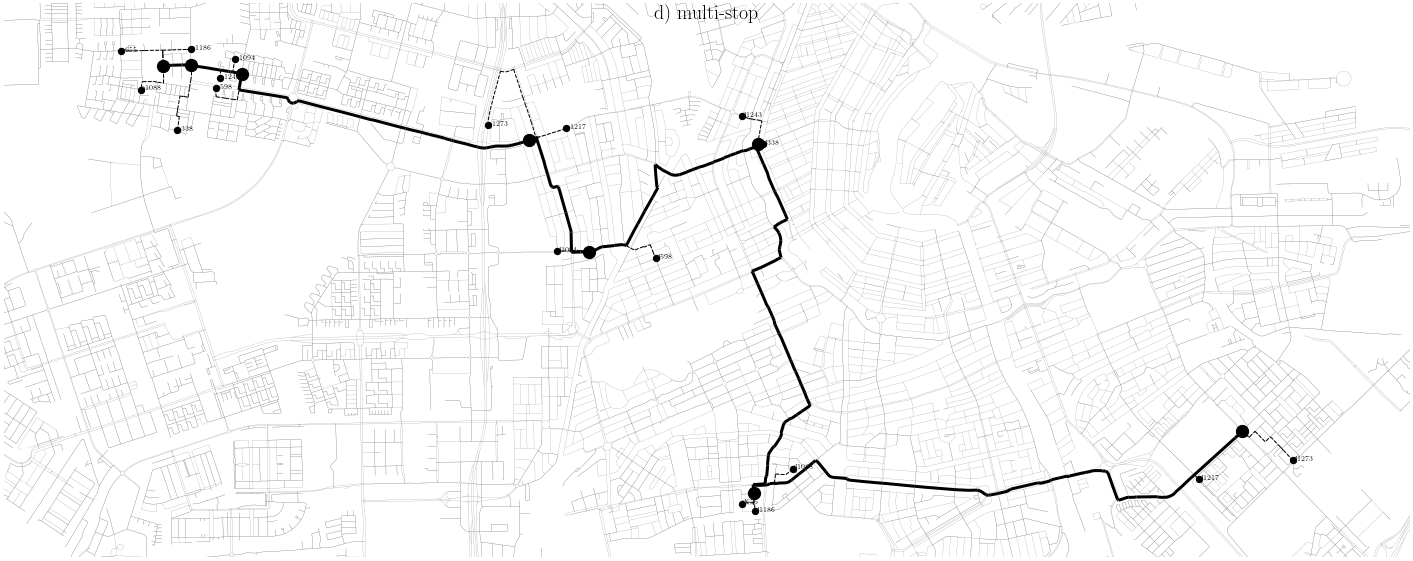

In [195]:
titles = ['a) private','b) door-to-door','c) stop-to-stop','d) multi-stop']
for level in [0,1,2,3]:
    visualizations.plot_ms(inData, ride_index, level = level, 
                           title = titles[level], fontsize = 7, figsize = (20,8))

In [202]:
import scipy
import math

In [208]:
scipy.special.binom(7800,9)*math.factorial(9)*math.factorial(9)

3.860195432451588e+40